# Global Temperature Change Analysis
We analize the annual global mean temperature anomalies provided by the [Goddard Institute for Space Studies (GISS)](https://data.giss.nasa.gov/gistemp/). The [dataset](https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv) is available for download as CSV file from the GISS website. This notebook follows an example from ch.4 of the book ["Time Series Forecasting in Python"](https://www.manning.com/books/time-series-forecasting-in-python-book) by M. Peixeiro, but uses a different dataset.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## The dataset
We download the dataset from the GISS website

In [2]:
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
ds_path = 'data/GLB.Ts+dSST.csv'
giss_temp = pd.read_csv(ds_path, header=1)
giss_temp.tail(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
142,2022,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86
143,2023,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41


In [3]:
year_index = pd.date_range('1880', '2024', freq='Y')
giss_temp.set_index(year_index, inplace=True)
giss_temp.drop('Year', axis=1, inplace=True)
giss_temp.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880-12-31,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19
1881-12-31,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19


We compute the annual means from the mean temperature anomalies of each month.  

In [4]:
annual_mean = []
for index, row in giss_temp.iterrows():
    sum = 0
    months = 0
    for col in giss_temp.columns[0:12]:
        sum += row[col]  
    annual_mean.append(round(sum / 12, 2))

We add the annual mean to the dataset

In [5]:
giss_temp['Annual Mean'] = annual_mean
giss_temp.tail(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean
2022-12-31,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86,0.89
2023-12-31,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41,1.17


## Uncertainty
The uncertainty is provided in an additional [file](https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv) available from the [GISS](https://data.giss.nasa.gov/gistemp/graphs_v4/) website

In [6]:
url_error_data = 'https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv'
error_ds_path = 'data/totalCI_ERA.csv'
error_data = pd.read_csv(error_ds_path)
error_data['ci95'].astype(float)
error = error_data['ci95']
error_data['ci95'] = error.apply(lambda error: round(error, 2)) 
error_data.tail(2)

,year,ci95
142,2022,0.05
143,2023,0.05


In [7]:
num_years = len(giss_temp)
print('Number of years of recorded anomalies: {0:d}'.format(num_years))

Number of years of recorded anomalies: 144


In [8]:
giss_temp['Uncertainty'] = error_data['ci95'].tolist()
giss_temp['Uncertainty']
giss_temp.tail(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean,Uncertainty
2022-12-31,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86,0.89,0.05
2023-12-31,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41,1.17,0.05


We plot the data of the global mean temperature anomalies from 1880 to 2023 with the error bars

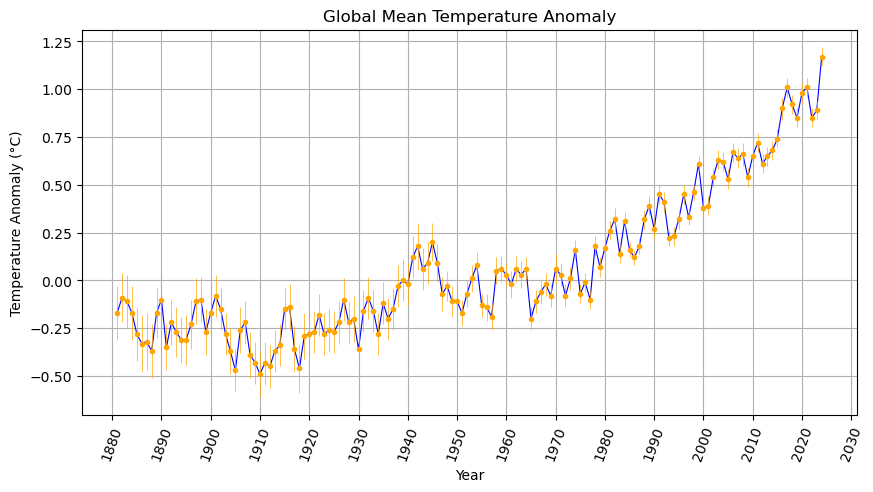

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Mean Temperature Anomaly')
ax.set_ylabel('Temperature Anomaly (°C)')
ax.set_xlabel('Year')
ax.set_xticks(giss_temp.index)
ax.set_xticklabels(giss_temp.index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_giss_temp = ax.plot(giss_temp['Annual Mean'], linewidth=0.8, label='temp.anom', color='blue')
plt_giss_error= ax.errorbar(giss_temp.index, giss_temp['Annual Mean'], yerr=giss_temp['Uncertainty'], linewidth=0.5, color='orange', fmt='.k');
#plt.legend(loc='upper left')
#plt.savefig('giss_anomaly.png', dpi=300)

## Models
We test different models of the process that can represent the temperature anomalies. We start with a simple random walk process and after that we test a moving average model.  

### Random walk
The random walk is a process for which the value of a variable y at time t, $y_t$, depends on its value at time t-1, $y_{t-1}$, a constant value $\delta$, and on a random component $\epsilon$

$$y_t = y_{t-1} + \delta + \epsilon$$

Using this model we assume that the value of a variable y is the result of a cumulative sum of random values sampled from a distribution, for example a gaussian distribution. 

$$y_t = \sum_{i=1}^{t-1} \epsilon_i$$

If we assume for simplicity that $\delta = 0$, we can see that

$$y_t - y_{t-1} = \epsilon$$

that is the difference between two values is only a random value. This result means that the statistical properties, i.e. mean value, standard deviation, and autocorrelation of the difference don't change or are stationary. The randowm walk model, the moving average model (MA), the autoregressive model (AR) and the autoregressive moving average model (ARMA) are all stationary. 

### Stationarity
We test the dataset for stationarity. We already know from the plot that the process is not stationary but there is a test that can be used to verify the stationarity of a time-series called [Augmented Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) or ADF. The ADF test searches for a unit root ($\alpha = 1$) of the equation

$$y_t - \alpha y_{t-1} = \delta + \epsilon$$

If $\alpha$ is indeed unitary the time-series is not stationary. if $-1<\alpha<1$ the time series is stationary. The ADF test returns also a p-value. If p = 0.05 or less we can be confident of the result at 95% or more. For example if $\alpha$ = 0.5 and p = 0.01, then the process is stationary, if $\alpha$ = 1.0 and p = 0.05 then the process is nonstationary.

### Standard deviation
The standard deviation of the process, in case it is a random walk, should be constant and equal to the standard deviation of the $\epsilon$ component.

### Autocorrelation
We said that a stationary process must have a constant mean value, standard deviation and autocorrelation. We can test for the autocorrelation between two values with a unitary lag, i.e. $y_t$ and $y_{t-1}$, or a lag of 2, e.g. $y_t$ and $y_{t-2}$, or more.

### ADF test
The ADF test for the global temperature anomalies returns a value greater thann 1 and with a p-value greater than 0.05 so we cannot reject the null hypothesis that the process is not stationary. 

In [11]:
ADF_result = adfuller(giss_temp['Annual Mean'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 1.4641340696516245
p-value: 0.9973868775709003


### First-order difference
We compute the first-order difference of the global temperature anomalies time series. The difference removes the trend and might be stationary

In [12]:
giss_temp_diff = np.diff(giss_temp['Annual Mean'], n=1)
giss_temp_diff_df = pd.DataFrame({'Diff': giss_temp_diff}, index=year_index[1:])

In [13]:
giss_temp_diff.size

143

When we plot the first-order difference time-series we can see that it looks stationary with the values randomly distributed around a 0 mean value. 

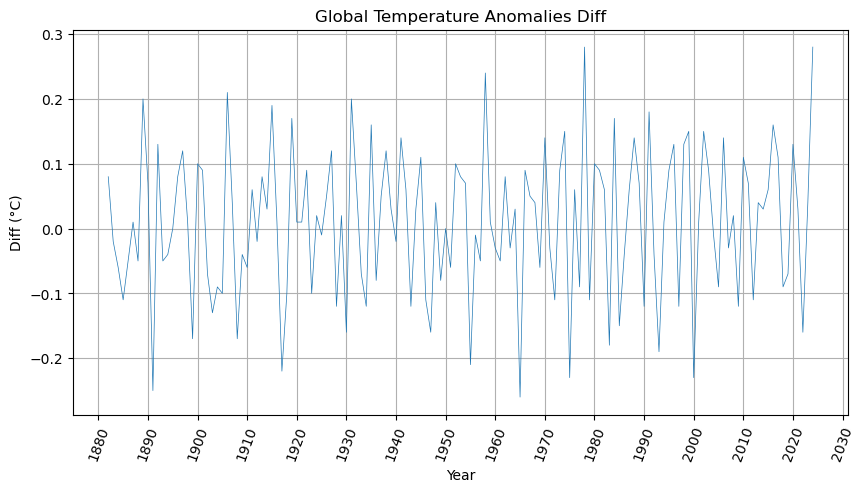

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Temperature Anomalies Diff')
ax.set_ylabel('Diff (°C)')
ax.set_xlabel('Year')
ax.set_xticks(giss_temp_diff_df.index)
ax.set_xticklabels(giss_temp_diff_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_google_diff = ax.plot(giss_temp_diff_df, linewidth=0.5, label='anom.diff')
#plt.legend(loc='upper left')

Nonetheless we apply the ADF test to the first-order difference to assess whether it is stationary. Since the output is lower than -1 and the p-value is lower than 0.05 we can reject the null hypothesis that the difference time series is not stationary. 

In [15]:
ADF_result = adfuller(giss_temp_diff_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.562154289780749
p-value: 2.990356395695225e-11


### Autocorrelation
Now we test for the autocorrelation of the first-order difference. The autocorrelation function measures the linear correlation between the current and the past values of a variable. We can see in the autocorrelation plot that there are two consecutive lag values, lag = 1 and lag = 2 with the autocorrelation that look somewhat significant. In this case a random walk model is not appropriate to represent the time-series. In the next section since the first two coefficients of the autocorrelation function are significant we will test the moving average model to see whether it can provide a better performance. From the autocorrelation function we can see that the coefficients beyond the first two are not significant but nonetheless not zero so it might be that an autoregressive model is more appropriate to represent our data.

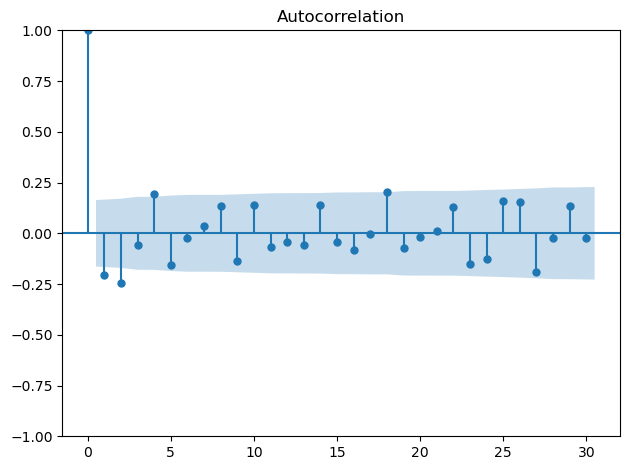

In [16]:
plot_acf(giss_temp_diff_df, lags=30)
plt.tight_layout()

### Moving Average (MA)
We want to see whether another model, the moving average model, can better represent the first-order difference time-series. In a moving average model of order q, MA(q), the value of a variable at time $y_t$ depends on a linear combination of the mean value of the time-series $\mu$ the present error term $\epsilon_t$ and the q previous error terms

$$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + .. + \theta_q \epsilon_{t-q}$$

The same expression for a moving average model of order 1 is

$$y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1}$$

We have seen that the first-order difference temperature anomalies has the coefficients of lag 1 and 2 so we can test whether the moving average model of order 2, MA(2), can represent it.

## Forecasts
We set up three models to forecast the global temperature anomalies. The "mean" model will simply forecast the mean value of the time-series, while the "last" model will forecast the last value. These two model will be used as a baseline to assess the performance of the MA(2) model. We split the 143 annual records into a test set of 128 records (90%) and a test set of 15 records.    

In [17]:
train = giss_temp_diff_df[:int(0.9*len(giss_temp_diff_df))]
test = giss_temp_diff_df[int(0.9*len(giss_temp_diff_df)):]
print('Training dataset size: {0:d}\nTest dataset size: {1:d}'.format(len(train), len(test)))

Training dataset size: 128
Test dataset size: 15


We define a function that takes as input the train dataset, the method name, and the horizon, that is the time window of the forecast that has the same size as the test set, and outputs the predictions as a list. 

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2)) # MA(q=2)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA
    
    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0)) # AR(p=3)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR
        
    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

We plot the global temperature anomalies and the first-order difference time-series highlighting the time horizon used to test the performance of the MA(2) model against the baselines.

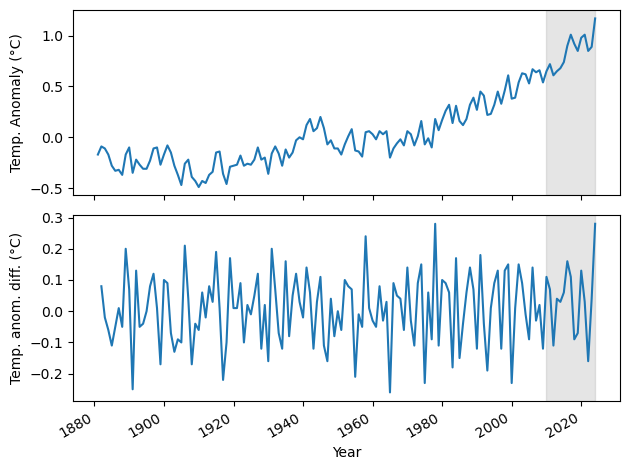

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(giss_temp['Annual Mean'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Temp. Anomaly (°C)')
ax1.axvspan('2009-12-31', '2023-12-31', color='#808080', alpha=0.2)

ax2.plot(giss_temp_diff_df['Diff'])
ax2.set_xlabel('Year')
ax2.set_ylabel('Temp. anom. diff. (°C)')
ax2.axvspan('2009-12-31', '2023-12-31', color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [20]:
pred_df = test.copy()
len(pred_df)

15

In [21]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
print('Train: {0:d}\nHorizon: {1:d}'.format(TRAIN_LEN, HORIZON))

Train: 128
Horizon: 15


In [22]:
pred_mean = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [23]:
len(pred_MA)

16

In [24]:
pred_df['pred_mean'] = pred_mean[:HORIZON]
pred_df['pred_last_value'] = pred_last_value[:HORIZON]
pred_df['pred_MA'] = pred_MA[:HORIZON]
pred_df

,Diff,pred_mean,pred_last_value,pred_MA
2009-12-31,0.11,0.005547,-0.12,0.024366
2010-12-31,0.07,0.005547,-0.12,0.020325
2011-12-31,-0.11,0.006846,0.07,-0.047628
2012-12-31,0.04,0.006846,0.07,-0.016812
2013-12-31,0.03,0.006212,0.04,0.000195
2014-12-31,0.06,0.006212,0.04,-0.006958
2015-12-31,0.16,0.006791,0.06,-0.034961
2016-12-31,0.11,0.006791,0.06,-0.016003
2017-12-31,-0.09,0.008676,0.11,-0.103418
2018-12-31,-0.07,0.008676,0.11,-0.039158


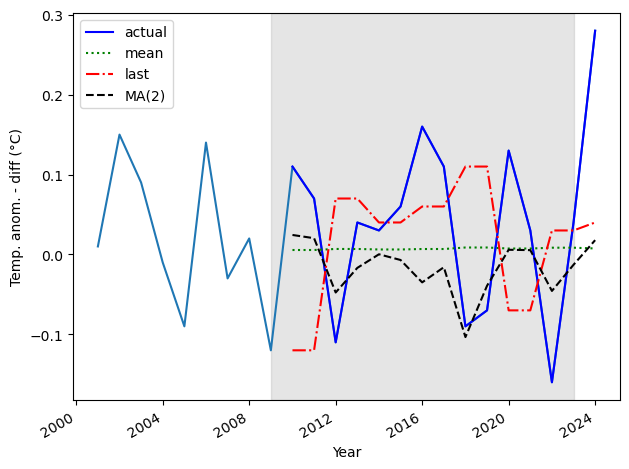

In [25]:
fig, ax = plt.subplots()
ax.plot(giss_temp_diff_df['Diff']['2000':])
ax.plot(pred_df['Diff']['2000':], 'b-', label='actual')
ax.plot(pred_df['pred_mean']['2000':], 'g:', label='mean')
ax.plot(pred_df['pred_last_value']['2000':], 'r-.', label='last')
ax.plot(pred_df['pred_MA']['2000':], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. anom. - diff (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

We compute the mean squared error (MSE) for the three models. The MA(2) model is slightly better than the other two baseline models.

In [26]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['Diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['Diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['Diff'], pred_df['pred_MA'])

print('MSE mean: {0:.3f}\nMSE last: {1:.3f}\nMSE MA(2): {2:.3f}'.format(mse_mean, mse_last, mse_MA))

MSE mean: 0.014
MSE last: 0.023
MSE MA(2): 0.012


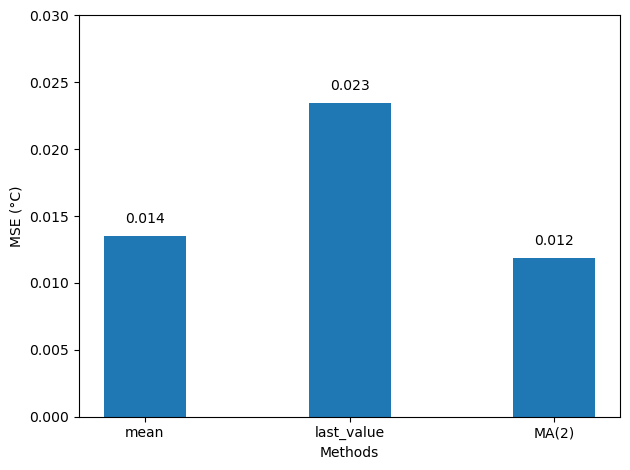

In [27]:
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE (°C)')
ax.set_ylim(0, 0.03)
for index, value in enumerate(y):
    plt.text(x=index, y = value + 0.001, s=str(round(value, 3)), ha='center')
plt.tight_layout()

We have to invserse-transform the predictions for first-order difference of the MA(2) model to get the predictions for the global temperature anomalies.

In [45]:
giss_temp['Prediction MA'] = pd.Series()
giss_temp['Prediction MA']['2009':] = giss_temp['Annual Mean']['2009':] + pred_df['pred_MA'].cumsum()
#giss_temp['Prediction']['2009':] = giss_temp['Annual Mean']['2009':] + pred_df['pred_mean'].cumsum()
giss_temp['Prediction MA']['2009':]

2009-12-31    0.674366
2010-12-31    0.764691
2011-12-31    0.607063
2012-12-31    0.630252
2013-12-31    0.660446
2014-12-31    0.713488
2015-12-31    0.838528
2016-12-31    0.932525
2017-12-31    0.739107
2018-12-31    0.629949
2019-12-31    0.765788
2020-12-31     0.80117
2021-12-31    0.595498
2022-12-31    0.622582
2023-12-31    0.920457
Freq: A-DEC, Name: Prediction MA, dtype: object

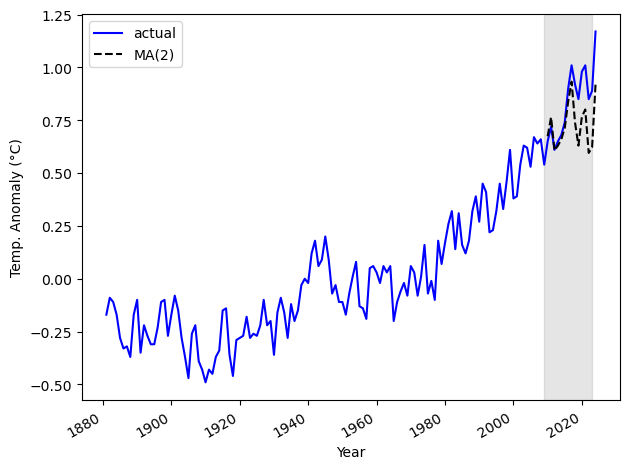

In [46]:
fig, ax = plt.subplots()
ax.plot(giss_temp['Annual Mean'], 'b-', label='actual')
ax.plot(giss_temp['Prediction MA'], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. Anomaly (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

Finally, we compute the mean absolute error for the predictions of the global annual mean temperature anomalies made using the MA(2) model.

In [52]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(giss_temp['Annual Mean']['2009':], giss_temp['Prediction']['2009':])
print('MSE for the predictions of the Global Annuall Mean Temperature Anomalies: {0:.3f} °C'.format(mae_MA_undiff))

MSE for the predictions of the Global Annuall Mean Temperature Anomalies: 0.125 °C


## Autoregressive (AR)
In an autoregressive process the output variable $y_t$ depends linearly on its previous values

$$y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + .. + \phi_p y_{t-p} + \epsilon_t$$

where $\delta$ is a constant and $\epsilon_t$ an error term. The index p represents the order of the autoregressive process AR(p), that is the number of previous values that are taken into account to predict the actual value of the output. For example, the output variable of an autoregressive process of order 1 is represented by

$$y_t = \delta + \phi_1 y_{t-1} + \epsilon_1$$

This is the same equation of a random walk process so we can say that a random walk is an autoregressive process of order 1, that is AR(1). Now, as for the MA(q) process, we have to find out which is the order p of the AR(p) model that better describes our process, or in other words on how many past values depends the current value of the output variable.

### Partial autocorrelation
The partial autocorrelation function is used to infer the order p of an autoregressive stationary process. 

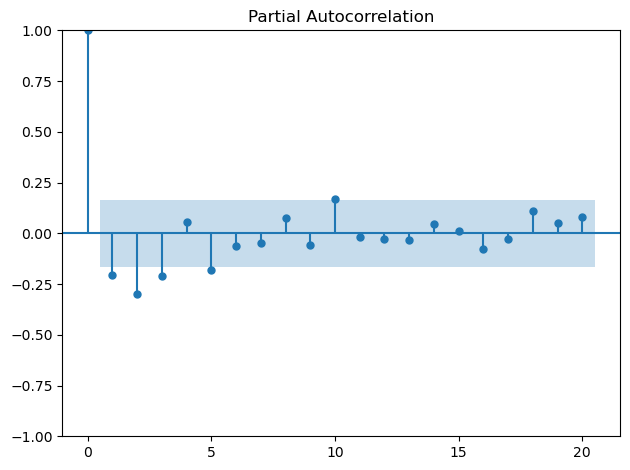

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(giss_temp_diff_df, lags=20);
plt.tight_layout()

In [34]:
WINDOW = 1
pred_AR = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

In [37]:
pred_df['pred_AR'] = pred_AR

In [38]:
pred_df

,Diff,pred_mean,pred_last_value,pred_MA,pred_AR
2009-12-31,0.11,0.005547,-0.12,0.024366,0.041978
2010-12-31,0.07,0.005547,-0.12,0.020325,-0.003425
2011-12-31,-0.11,0.006846,0.07,-0.047628,-0.034224
2012-12-31,0.04,0.006846,0.07,-0.016812,-0.010020
2013-12-31,0.03,0.006212,0.04,0.000195,0.007734
2014-12-31,0.06,0.006212,0.04,-0.006958,0.000052
2015-12-31,0.16,0.006791,0.06,-0.034961,-0.040591
2016-12-31,0.11,0.006791,0.06,-0.016003,-0.081573
2017-12-31,-0.09,0.008676,0.11,-0.103418,-0.098572
2018-12-31,-0.07,0.008676,0.11,-0.039158,-0.038921


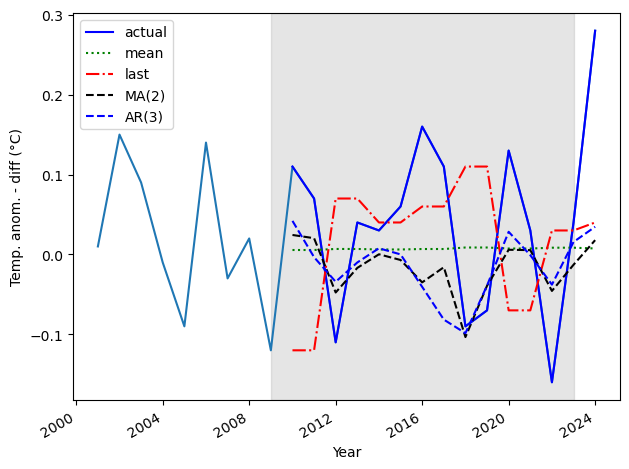

In [40]:
fig, ax = plt.subplots()
ax.plot(giss_temp_diff_df['Diff']['2000':])
ax.plot(pred_df['Diff']['2000':], 'b-', label='actual')
ax.plot(pred_df['pred_mean']['2000':], 'g:', label='mean')
ax.plot(pred_df['pred_last_value']['2000':], 'r-.', label='last')
ax.plot(pred_df['pred_MA']['2000':], 'k--', label='MA(2)')
ax.plot(pred_df['pred_AR']['2000':], 'b--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. anom. - diff (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

In [41]:
mse_AR = mean_squared_error(pred_df['Diff'], pred_df['pred_AR'])
print('MSE AR(3): {0:.3f}'.format(mse_AR))

MSE AR(3): 0.012


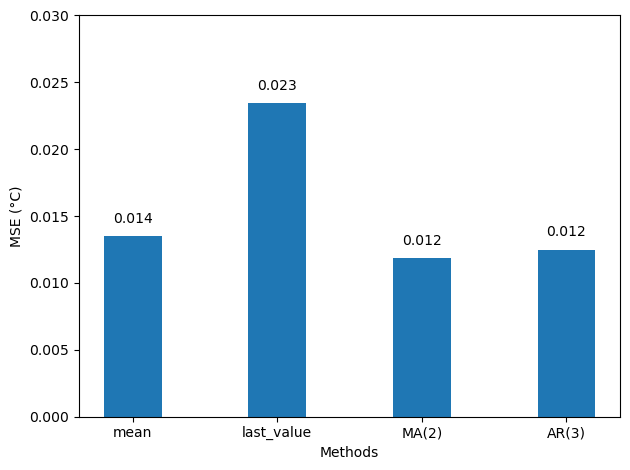

In [44]:
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'MA(2)', 'AR(3)']
y = [mse_mean, mse_last, mse_MA, mse_AR]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE (°C)')
ax.set_ylim(0, 0.03)
for index, value in enumerate(y):
    plt.text(x=index, y = value + 0.001, s=str(round(value, 3)), ha='center')
plt.tight_layout()

In [47]:
giss_temp['Prediction AR'] = pd.Series()
giss_temp['Prediction AR']['2009':] = giss_temp['Annual Mean']['2009':] + pred_df['pred_AR'].cumsum()
giss_temp['Prediction AR']['2009':]

2009-12-31    0.691978
2010-12-31    0.758553
2011-12-31    0.614328
2012-12-31    0.644308
2013-12-31    0.682043
2014-12-31    0.742095
2015-12-31    0.861504
2016-12-31    0.889931
2017-12-31    0.701359
2018-12-31    0.592438
2019-12-31    0.750758
2020-12-31    0.779825
2021-12-31    0.582016
2022-12-31    0.637616
2023-12-31    0.952249
Freq: A-DEC, Name: Prediction AR, dtype: object

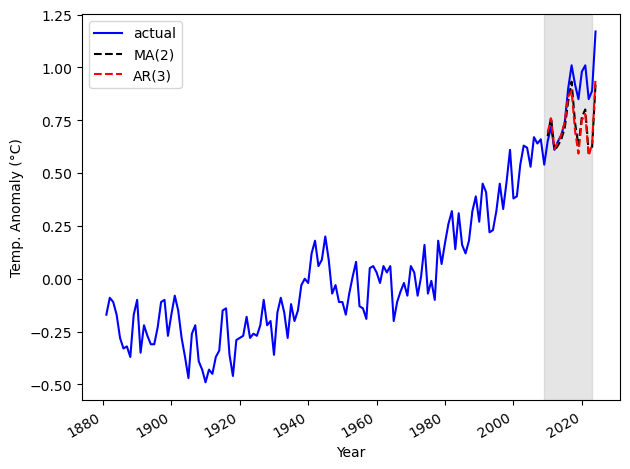

In [49]:
fig, ax = plt.subplots()
ax.plot(giss_temp['Annual Mean'], 'b-', label='actual')
ax.plot(giss_temp['Prediction MA'], 'k--', label='MA(2)')
ax.plot(giss_temp['Prediction AR'], 'r--', label='AR(3)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. Anomaly (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

In [51]:
mae_AR_undiff = mean_absolute_error(giss_temp['Annual Mean']['2009':], giss_temp['Prediction AR']['2009':])
print('MSE for the predictions of the Global Annuall Mean Temperature Anomalies: {0:.3f} °C'.format(mae_AR_undiff))

MSE for the predictions of the Global Annuall Mean Temperature Anomalies: 0.128 °C


## Autoregressive moving average (ARMA)
The ARMA(p,q) model is a combination of an AR(p) and a MA(q) model.

$$y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + .. + \phi_p y_{t-p} + \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + .. + \theta_q \epsilon_{t-q}$$

We have to find the orders p and q of an ARMA(p,q) model that can represent our time series.

### Akaike information criterion (AIC)
We have to test several ARMA(p,q) models and select the best among them according to a criterion. One such criterion is the Akaike Information Criterion or AIC. The AIC is a balance between the complexity of the model, i.e. its number of parameters p and q, and its ability to fit the data, or likelihood $\hat{L}$

$$AIC = 2*(p + q) - 2log(\hat{L})$$

The lower the value of the AIC the better the model.

In [54]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [57]:
from typing import Union
from tqdm import tqdm_notebook

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

The Akaike test shows that the ARMA model with p = 1 and q = 3 is the best model of the first order differences of the global temperature anomalies.

In [58]:
result_df = optimize_ARMA(train['Diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",-212.574863
1,"(3, 1)",-211.016401
2,"(3, 2)",-210.857438
3,"(0, 2)",-210.593371
4,"(3, 0)",-210.065558
5,"(3, 3)",-209.488403
6,"(2, 1)",-209.398407
7,"(1, 1)",-209.384527
8,"(2, 3)",-209.131177
9,"(0, 3)",-208.730369


Now in order to measure the performance of the selected model we have to estimate its residuals, the difference between estimated values of the model and the observed data. If the residuals are represented by a white noise distribution it means that the model is a good representation of the process and that it misses only the random component. One way to estimate the performance of the model is by a qualitativa analysisusing a Quantile-Quantile plot, or Q-Q plot.

In [59]:
model = SARIMAX(train['Diff'], order=(1,0,3), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Diff   No. Observations:                  128
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 111.287
Date:                Thu, 18 Jan 2024   AIC                           -212.575
Time:                        17:46:45   BIC                           -198.315
Sample:                    12-31-1881   HQIC                          -206.781
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9419      0.066    -14.281      0.000      -1.071      -0.813
ma.L1          0.6470      0.110      5.878      0.000       0.431       0.863
ma.L2         -0.5271      0.096     -5.476      0.0

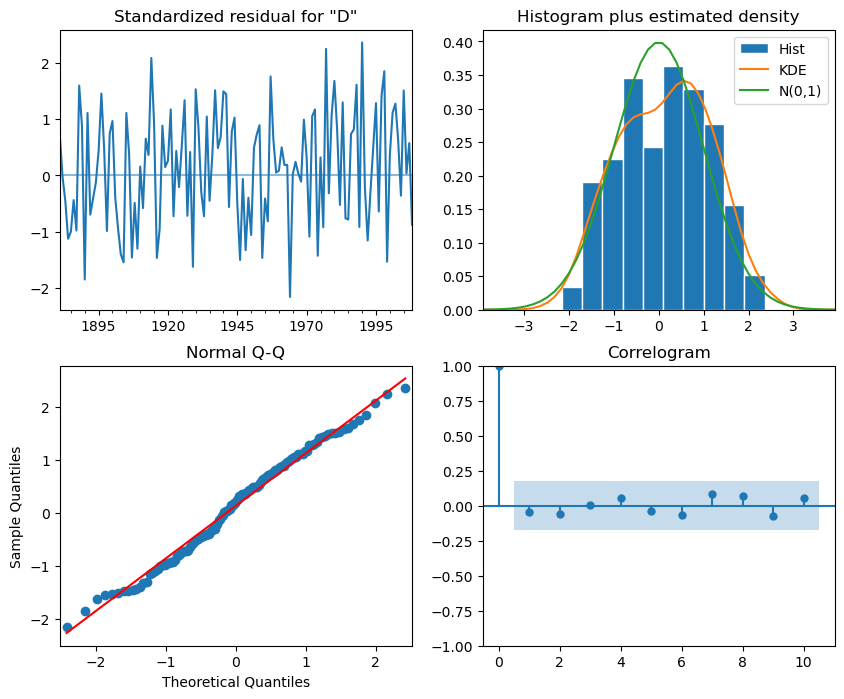

In [60]:
model_fit.plot_diagnostics(figsize=(10, 8));

The next step for the estimation of the selected model is to check that the residuals are indipendent or, in other words, that they are not correlated. To perform this test we use the Ljung-Box test with the null hypothesis that the data is not autocorrelated. If the p-value of the test is larger than 0.05 we cannot reject the null hypothesis and the data is not autocorrelated, if the p-value is smaller that 0.05 we can reject the null hypothesis meaning that the data is autocorrelated. We compute the Ljung-Box test for 10 lags. **For some reasons the Ljung-Box test doesn't work so we rely only on the qualitative test above.**

In [99]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals.to_numpy(), lags=[10], return_df=True)
print(pvalue)

lb_pvalue


In [105]:
WINDOW = 2
pred_ARMA = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

In [107]:
pred_df['pred_ARMA'] = pred_ARMA[:HORIZON]
pred_df

,Diff,pred_mean,pred_last_value,pred_MA,pred_AR,pred_ARMA
2009-12-31,0.11,0.005547,-0.12,0.024366,0.041978,0.023894
2010-12-31,0.07,0.005547,-0.12,0.020325,-0.003425,0.005808
2011-12-31,-0.11,0.006846,0.07,-0.047628,-0.034224,-0.024973
2012-12-31,0.04,0.006846,0.07,-0.016812,-0.010020,-0.049574
2013-12-31,0.03,0.006212,0.04,0.000195,0.007734,0.019193
2014-12-31,0.06,0.006212,0.04,-0.006958,0.000052,-0.025919
2015-12-31,0.16,0.006791,0.06,-0.034961,-0.040591,-0.024220
2016-12-31,0.11,0.006791,0.06,-0.016003,-0.081573,-0.026938
2017-12-31,-0.09,0.008676,0.11,-0.103418,-0.098572,-0.094318
2018-12-31,-0.07,0.008676,0.11,-0.039158,-0.038921,-0.057114


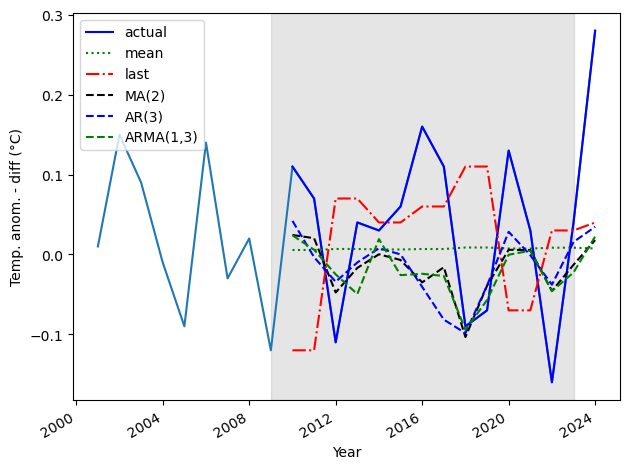

In [109]:
fig, ax = plt.subplots()
ax.plot(giss_temp_diff_df['Diff']['2000':])
ax.plot(pred_df['Diff']['2000':], 'b-', label='actual')
ax.plot(pred_df['pred_mean']['2000':], 'g:', label='mean')
ax.plot(pred_df['pred_last_value']['2000':], 'r-.', label='last')
ax.plot(pred_df['pred_MA']['2000':], 'k--', label='MA(2)')
ax.plot(pred_df['pred_AR']['2000':], 'b--', label='AR(3)')
ax.plot(pred_df['pred_ARMA']['2000':], 'g--', label='ARMA(1,3)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. anom. - diff (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

In [110]:
mse_ARMA = mean_squared_error(pred_df['Diff'], pred_df['pred_ARMA'])
print('MSE ARMA(1,3): {0:.3f}'.format(mse_ARMA))

MSE ARMA(1,3): 0.013


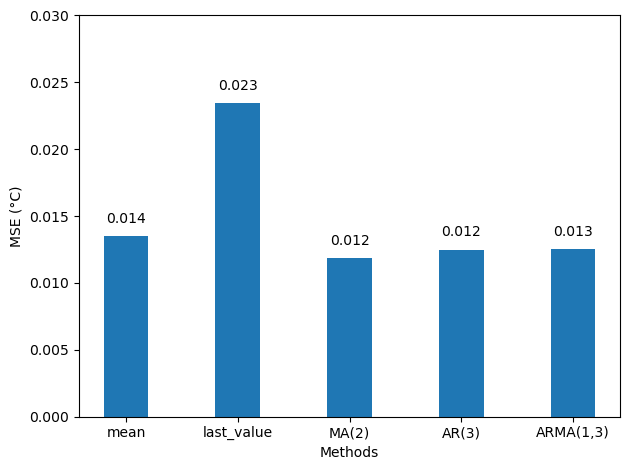

In [111]:
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'MA(2)', 'AR(3)', 'ARMA(1,3)']
y = [mse_mean, mse_last, mse_MA, mse_AR, mse_ARMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE (°C)')
ax.set_ylim(0, 0.03)
for index, value in enumerate(y):
    plt.text(x=index, y = value + 0.001, s=str(round(value, 3)), ha='center')
plt.tight_layout()

In [112]:
giss_temp['Prediction ARMA'] = pd.Series()
giss_temp['Prediction ARMA']['2009':] = giss_temp['Annual Mean']['2009':] + pred_df['pred_ARMA'].cumsum()
giss_temp['Prediction ARMA']['2009':]

2009-12-31    0.673894
2010-12-31    0.749702
2011-12-31    0.614729
2012-12-31    0.605155
2013-12-31    0.654348
2014-12-31    0.688429
2015-12-31    0.824209
2016-12-31    0.907272
2017-12-31    0.722954
2018-12-31     0.59584
2019-12-31    0.725471
2020-12-31    0.760106
2021-12-31    0.554134
2022-12-31     0.57153
2023-12-31    0.873909
Freq: A-DEC, Name: Prediction ARMA, dtype: object

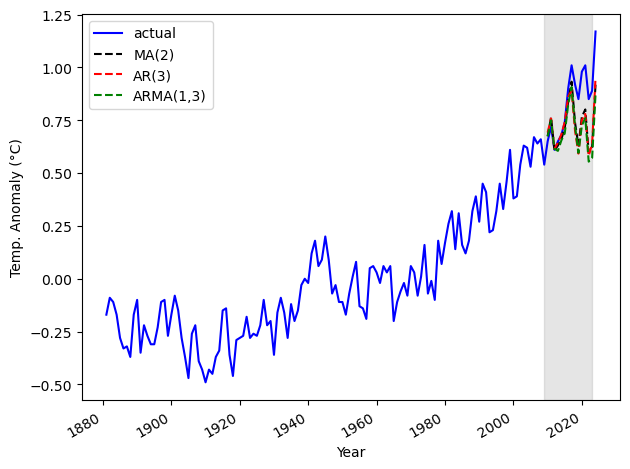

In [114]:
fig, ax = plt.subplots()
ax.plot(giss_temp['Annual Mean'], 'b-', label='actual')
ax.plot(giss_temp['Prediction MA'], 'k--', label='MA(2)')
ax.plot(giss_temp['Prediction AR'], 'r--', label='AR(3)')
ax.plot(giss_temp['Prediction ARMA'], 'g--', label='ARMA(1,3)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. Anomaly (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

In [115]:
mae_ARMA_undiff = mean_absolute_error(giss_temp['Annual Mean']['2009':], giss_temp['Prediction ARMA']['2009':])
print('MSE for the predictions of the Global Annuall Mean Temperature Anomalies: {0:.3f} °C'.format(mae_ARMA_undiff))

MSE for the predictions of the Global Annuall Mean Temperature Anomalies: 0.148 °C
